In [47]:
import warnings
warnings.filterwarnings('ignore')

# MNIST digit classification: Classical ML

## 1. The dataset

The MNIST dataset<sup>1</sup> (Modified National Institute of Standards and Technology dataset) is a large dataset containing pre-processed **28x28 pixel** images of handwritten digits. The dataset is widely used for training and testing in the field of machine learning.

<sub>[1] THE MNIST DATABASE of handwritten digits, Yann LeCun, Courant Institute, NYU Corinna Cortes, Google Labs, New York Christopher J.C. Burges, Microsoft Research, Redmond.</sub>

Let's load this dataset. As this is a widely used dataset in Machine Learning, it can be loaded straight from the [openml.org](https://www.openml.org/) public repository with the following Scikit-learn function: 

In [48]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

The `fetch_openml()` function returns a Python [dictionary-like object](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html). The actual data can be obtained with the following keys:

- data: np.array, scipy.sparse.csr_matrix of floats, or pandas DataFrame
- target: np.array, pandas Series or DataFrame

Let's explore the feature vectors:

In [49]:
print("Length of feature vector: {}\n".format(len(mnist.data[0])))
print("Example of feature vector:\n")
print(mnist.data[0])

Length of feature vector: 784

Example of feature vector:

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 25

Each image in the loaded dataset is represented by a 784 dimensional vector with one gray-scale value (0 means black, 255 means white) for each of the 28x28 pixels.

We can reshape this feature vector to the gray-scaled image as follows:

In [50]:
mnist.data[0].reshape((28,28))

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

We will denote the feature vectors as `X` and the corresponding labels as `y`:

In [51]:
X = mnist.data
y = mnist.target

print(X.dtype)
print(y.dtype)

float64
object


Notice that the labels are Python objects (strings):

In [52]:
print(y)

['5' '0' '4' ... '4' '5' '6']


We convert these to numbers (integers):

In [53]:
y = mnist.target.astype('int64')

We can use the Python [matplotlib](https://matplotlib.org/) library to plot the digit images in `X` (the label for each image is shown in the title):

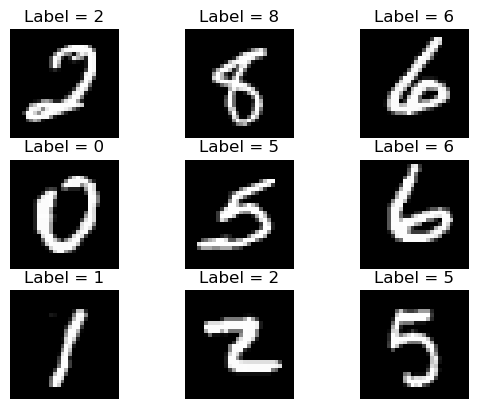

In [54]:
import matplotlib.pyplot as plt
from random import randint

# Display 9 randomly selected images
for c in range(1, 10):
    plt.subplot(3, 3,c)
    i = randint(0,X.shape[0])
    im = X[i].reshape((28,28))
    plt.axis("off")
    plt.title("Label = {}".format(y[i]))
    plt.imshow(im, cmap='gray')

It is 'best practice' in Machine Learning to normalize the feature values such that all features have values with the same 'not to large' scale. This facilitates faster convergence during training.

Scikit-learn has functions to normalize features in `sklearn.preprocessing`. The most common ones are [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

We will use the `MinMaxScaler()`:

In [105]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

print(X[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

To evaluate our trained model we need to first create an independent test set with images that are not used during training:

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True, random_state=42)

## 2. The model

Now we are ready to define our model. We will fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model:

In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

Each Scikit-learn model has a function `fit()` that optimizes the modelparameters to minimize the cost function:

In [58]:
clf.fit(X_train,y_train)

LogisticRegression()

We can access the modelparameters of the fitted logistic regression model as follows: 

In [71]:
print(clf.coef_)
print(clf.intercept_)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-1.03989462  1.1959033   0.00848779 -0.71122713  0.22600493  1.95644601
 -0.3878861   1.55821503 -2.25246606 -0.55358315]


As the Scikit-learn implementation of logistic regression performs a one-vs-all multi-class apporach we get 10 lists of modelparameters and 10 intercepts, one for each of the 10 classes.

Let's plot the modelparameters for each class as a 28x28 image:

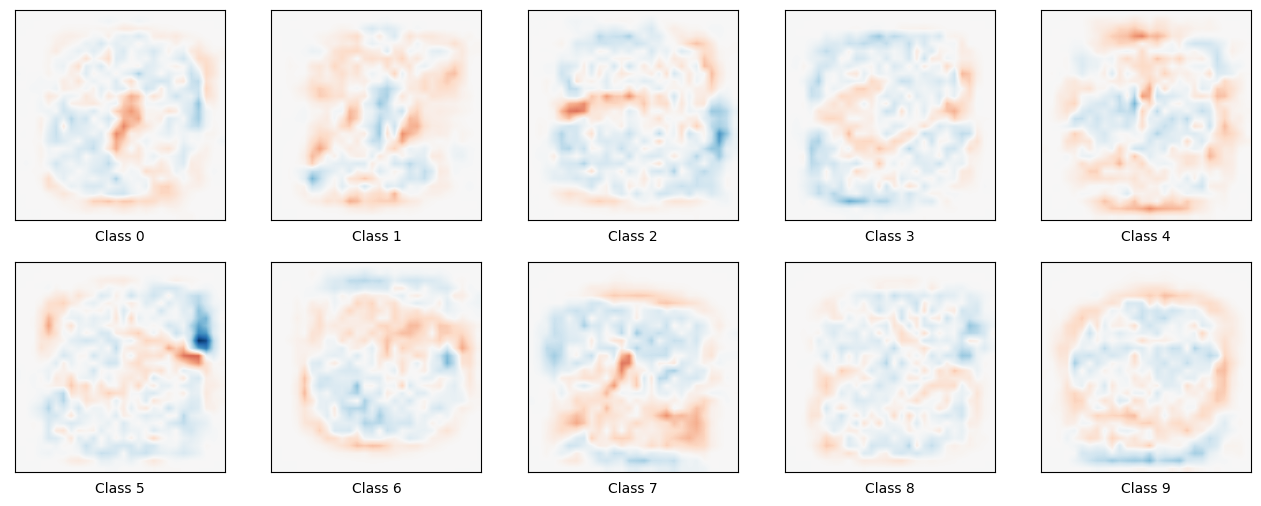

In [74]:
import numpy as np

coef = clf.coef_
scale = np.abs(coef).max()
plt.figure(figsize=(16,6))

for i in range(10): # 0-9
    coef_plot = plt.subplot(2, 5, i + 1) # 2x5 plot

    coef_plot.imshow(coef[i].reshape(28,28), 
                     cmap=plt.cm.RdBu,
                     vmin=-scale, vmax=scale,
                    interpolation='bilinear')
    
    coef_plot.set_xticks(()); coef_plot.set_yticks(()) # remove ticks
    coef_plot.set_xlabel(f'Class {i}')

Each Scikit-learn model also has a function `predict()` that applies the fitted model to compute class lables for feature vectors:

In [60]:
# Perform the predictions
y_predicted = clf.predict(X_test)

print(y_predicted)

[8 4 5 ... 7 7 2]


## 3. Evaluation

Scikit-learn offers many [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluating the prediction performance. The most common metric is `accuracy`:

In [64]:
from sklearn.metrics import accuracy_score

print("Accuracy = {}%".format(accuracy_score(y_test, y_predicted)*100))

Accuracy = 91.94285714285715%


To get more insight into the prediction errors for each class we can compute a confusion matrix:

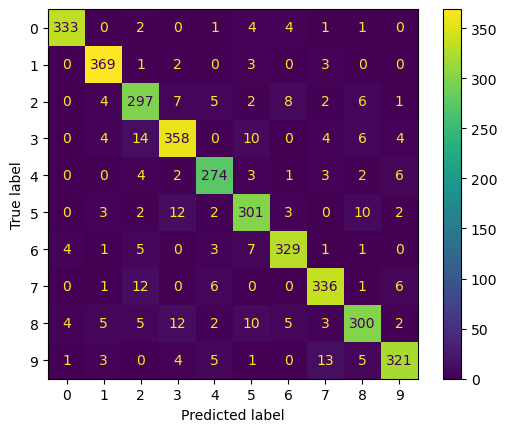

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
plt.show()

Scikit-learn also offers a `classification_report()` function that computes metrics that are more suitable for imbalanced multi-class classification tasks:

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted, labels=range(0,10)))

Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       346
           1       0.95      0.98      0.96       378
           2       0.87      0.89      0.88       332
           3       0.90      0.90      0.90       400
           4       0.92      0.93      0.92       295
           5       0.88      0.90      0.89       335
           6       0.94      0.94      0.94       351
           7       0.92      0.93      0.92       362
           8       0.90      0.86      0.88       348
           9       0.94      0.91      0.92       353

    accuracy                           0.92      3500
   macro avg       0.92      0.92      0.92      3500
weighted avg       0.92      0.92      0.92      3500



Now, let's take a look a the misclassified images in the test set: 

In [75]:
index = 0
misclassified_images = []
for label, predict in zip(y_test, y_predicted):
    if label != predict: 
        misclassified_images.append(index)
    index +=1
    
print("Number of misclassified test set images: {}".format(len(misclassified_images)))

Number of misclassified test set images: 282


Let's plot some of these:

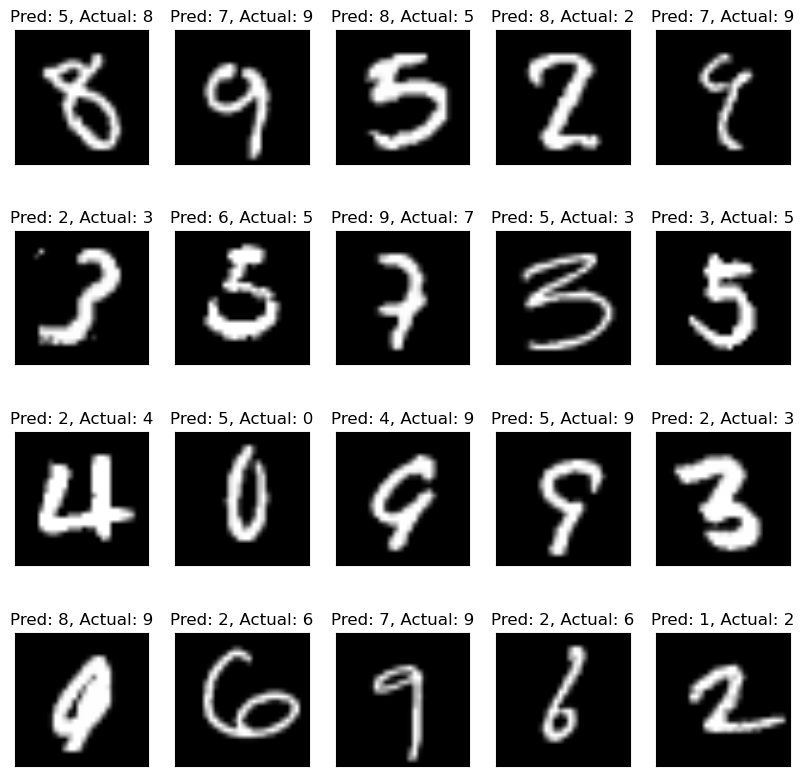

In [76]:
plt.figure(figsize=(10,10))
for plot_index, bad_index in enumerate(misclassified_images[0:20]):
    p = plt.subplot(4,5, plot_index+1) # 4x5 plot
    
    p.imshow(X_test[bad_index].reshape(28,28), cmap=plt.cm.gray,
            interpolation='bilinear')
    p.set_xticks(()); p.set_yticks(()) # remove ticks
    
    p.set_title(f'Pred: {y_predicted[bad_index]}, Actual: {y_test[bad_index]}');

## 4. Hyperparameter optimization

Scikit-learn offers [many functions](https://scikit-learn.org/stable/modules/grid_search.html) for hyperparameter optimization. We will use `GridSearchCV()` that evaluates different hyperparamter value combinations using cross-validation.

In `GridSearchCV()` you define the hyperparameter values to consider as a Python dictionary:  

In [78]:
from sklearn.model_selection import GridSearchCV

grid = {
    "C":np.logspace(-3,3,7)
}

print(grid)

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


Next, we can initialize `GridSearchCV()` just like any other model in Scikit-learn:

In [90]:
clf_cv = GridSearchCV(clf, grid, cv=5, verbose=2, scoring='f1_macro')

Now we can just call the `fit()` function again to fit all the models and evaluate their prediction performance with the cross-validation procedure:

In [95]:
clf_cv.fit(X_train_small,y_train_small)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ............................................C=0.001; total time=   8.2s
[CV] END ............................................C=0.001; total time=   8.7s
[CV] END ............................................C=0.001; total time=   8.5s
[CV] END ............................................C=0.001; total time=   8.7s
[CV] END ............................................C=0.001; total time=   8.1s
[CV] END .............................................C=0.01; total time=   8.3s
[CV] END .............................................C=0.01; total time=   8.8s
[CV] END .............................................C=0.01; total time=   9.1s
[CV] END .............................................C=0.01; total time=   8.2s
[CV] END .............................................C=0.01; total time=   7.0s
[CV] END ..............................................C=0.1; total time=   8.2s
[CV] END ........................................

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1_macro', verbose=2)

A fitted `GridSearchCV()` has an attribute `cv_results_` that contains the cross-validation scores for each of the hyperparameter value combinations considered. The following code creates a Pandas Dataframe from `cv_results_` for easy visualization:

In [96]:
import pandas as pd

result_cv = pd.DataFrame()
result_cv["param_C"] = clf_cv.cv_results_["param_C"].data
result_cv["score"] = clf_cv.cv_results_["mean_test_score"]

result_cv

,param_C,score
0,0.001,0.887451
1,0.01,0.910836
2,0.1,0.920228
3,1.0,0.918898
4,10.0,0.917717
5,100.0,0.917604
6,1000.0,0.917749


A fitted `GridSearchCV()` also has attributes `best_estimator_` and `best_score_` that contain the best performing model and its corresponding cross-validation score respectively: 

In [97]:
print(clf_cv.best_estimator_)
print(clf_cv.best_score_)

LogisticRegression(C=0.1)
0.9202280167397634


A fitted `GridSearchCV()` also has the function `predict()` that applies `best_estimator_` to predict the classes:

In [93]:
y_predicted = clf_cv.predict(X_test)

print(classification_report(y_test, y_predicted, labels=range(0,10)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       346
           1       0.92      0.97      0.94       378
           2       0.86      0.89      0.88       332
           3       0.89      0.89      0.89       400
           4       0.91      0.92      0.91       295
           5       0.88      0.87      0.88       335
           6       0.91      0.94      0.93       351
           7       0.91      0.92      0.92       362
           8       0.89      0.82      0.86       348
           9       0.93      0.90      0.91       353

    accuracy                           0.91      3500
   macro avg       0.91      0.91      0.91      3500
weighted avg       0.91      0.91      0.91      3500



The `predict()` function returns the classes only. The logisitic regression algorithm 'predicts' probabilities for each class. The `predict_proba()` functions returns these probabilities:

In [100]:
y_predicted = clf_cv.predict_proba(X_test)

These are the class probability predictions for the first instance in the test set `y_test`:

In [103]:
print(y_predicted[0])

[1.82807620e-08 6.17302904e-10 6.28446525e-06 1.41630914e-04
 1.58067351e-08 5.18854361e-04 6.59116873e-10 1.55869116e-09
 9.99332683e-01 5.10147203e-07]


This is the true class of this instance:

In [104]:
print(y_test[0])

8
